# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d100/188ba85c40dd8a863f49bd72a696f3553c10c912c4269b997cab7dd1.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Bratislava, Bratislava, Slovakia**, and the stations the data comes from are shown on the map below.

In [270]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import EngFormatter, StrMethodFormatter
import mplleaflet
import pandas as pd
import numpy as np

In [189]:
def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(100,'188ba85c40dd8a863f49bd72a696f3553c10c912c4269b997cab7dd1')

In [361]:
# load the data
temperatures = pd.read_csv('data/C2A2_data/BinnedCsvs_d100/188ba85c40dd8a863f49bd72a696f3553c10c912c4269b997cab7dd1.csv')
temperatures.head()
# temperatures.info() # (99762, 4)

,ID,Date,Element,Data_Value
0,AU000005010,2012-11-02,TMAX,119
1,AUM00011155,2007-06-14,TMIN,106
2,LOE00116364,2013-02-17,TMAX,-12
3,AUM00011389,2010-09-10,TMIN,115
4,EZM00011520,2011-11-06,TMIN,58


In [362]:
# remove leap days
temperatures['Date'] = pd.to_datetime(temperatures['Date'])
temperatures = temperatures[~ ((temperatures['Date'].dt.month == 2) & (temperatures['Date'].dt.day == 29))] # 56 entries removed 
# temperatures.info() # (99706, 4)

In [363]:
# subset the temperatures data
temperatures_2005_2014 = temperatures[(temperatures['Date'] >= '2005-01-01') & (temperatures['Date'] <= '2014-12-31')]
temperatures_2015 = temperatures[(temperatures['Date'] >= '2015-01-01') & (temperatures['Date'] <= '2015-12-31')]
# temperatures_2005_2014.info() # (92478, 4)
# temperatures_2015.info() # (7228, 4)

In [364]:
# find the minimum and maximum temperature for each day in a month regardless of the year
# (2005 - 2014)
min_temperatures_2005_2014 = (temperatures_2005_2014[(temperatures_2005_2014['Element'] == 'TMIN')]
                              .groupby(temperatures_2005_2014['Date'].dt.strftime('%m-%d'))['Data_Value']
                              .min()
                              )

max_temperatures_2005_2014 = (temperatures_2005_2014[(temperatures_2005_2014['Element'] == 'TMAX')]
                              .groupby(temperatures_2005_2014['Date'].dt.strftime('%m-%d'))['Data_Value']
                              .max()
                              )
# 2015
min_temperatures_2015 = (temperatures_2015[(temperatures_2015['Element'] == 'TMIN')]
                         .groupby(temperatures_2015['Date'].dt.strftime('%m-%d'))['Data_Value']
                         .min()
                         )

max_temperatures_2015 = (temperatures_2015[(temperatures_2015['Element'] == 'TMAX')]
                         .groupby(temperatures_2015['Date'].dt.strftime('%m-%d'))['Data_Value']
                         .max()
                         )

# min_temperatures_2005_2014.shape #(365,)
# max_temperatures_2005_2014.shape #(365,)

In [365]:
# calculate the deviations in 2015 from the period of 2005-2014
min_temp_dev = pd.concat([min_temperatures_2005_2014, min_temperatures_2015], axis=1)
max_temp_dev = pd.concat([max_temperatures_2005_2014, max_temperatures_2015], axis=1)

# rename the columns
min_temp_dev.columns = ['Temp_2005_2014', 'Temp_2015']
max_temp_dev.columns = ['Temp_2005_2014', 'Temp_2015']

# identify broken temperature record
min_temp_dev['Temp_record_broken'] = (np.where
                                      (min_temp_dev['Temp_2015'] < min_temp_dev['Temp_2005_2014'],
                                       min_temp_dev['Temp_2015'],
                                       -9999)
                                      )

min_temp_dev = min_temp_dev[min_temp_dev['Temp_record_broken'] != 9999]

max_temp_dev['Temp_record_broken'] = (np.where
                                      (max_temp_dev['Temp_2015'] > max_temp_dev['Temp_2005_2014'],
                                       max_temp_dev['Temp_2015'],
                                       -9999)
                                      )

max_temp_dev = max_temp_dev[max_temp_dev['Temp_record_broken'] != 9999]

# min_temp_dev[min_temp_dev['Temp_record_broken'] != -9999] # 17 entries in 2015 have lower minimum temperature than in 2005-2014
# min_temp_dev[min_temp_dev['Temp_2005_2014'] == min_temp_dev['Temp_2015']] # 1 entry

# max_temp_dev[max_temp_dev['Temp_record_broken'] != -9999] # 56 entries in 2015 have higher maximum temperature than in 2005-2014
# max_temp_dev[max_temp_dev['Temp_2005_2014'] == max_temp_dev['Temp_2015']] # 4 entries

In [366]:
# adjust the date index
min_temperatures_2005_2014.index = '2014-' + min_temperatures_2005_2014.index
min_temperatures_2005_2014.index = pd.to_datetime(min_temperatures_2005_2014.index)
max_temperatures_2005_2014.index = '2014-' + max_temperatures_2005_2014.index
max_temperatures_2005_2014.index = pd.to_datetime(max_temperatures_2005_2014.index)
min_temp_dev.index = '2014-' + min_temp_dev.index
min_temp_dev.index = pd.to_datetime(min_temp_dev.index)
max_temp_dev.index = '2014-' + max_temp_dev.index
max_temp_dev.index = pd.to_datetime(max_temp_dev.index)

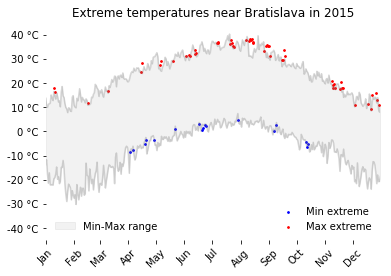

In [398]:
# plot the minimum and maximum temperatures using line chart (period: 2005 - 2014)
plt.figure()

# line chart
plt.plot(pd.to_datetime(min_temperatures_2005_2014.index),
         min_temperatures_2005_2014.values/10,
         color = 'grey',
         alpha = 0.3)
         
plt.plot(pd.to_datetime(max_temperatures_2005_2014.index),
         max_temperatures_2005_2014.values/10,
         color = 'grey',
         alpha = 0.3)

# fill the area between the min and max temperatures
line_chart_fill = plt.fill_between(min_temperatures_2005_2014.index.values, 
                                   min_temperatures_2005_2014.values/10,
                                   max_temperatures_2005_2014.values/10,
                                   color='grey',
                                   alpha= 0.1,
                                   label = 'Min-Max range')

# scatter plot overlay (year 2015)
scatter_plot_min = plt.scatter(min_temp_dev.index,
                               min_temp_dev['Temp_record_broken']/10,
                               s = 3,
                               color = 'blue',
                               label = 'Min extreme')

scatter_plot_max = plt.scatter(max_temp_dev.index,
                               max_temp_dev['Temp_record_broken']/10,
                               s = 3,
                               color = 'red',
                               label = 'Max extreme')


# chart tweaking
ax = plt.gca() # get current axes

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # display month on x-axis
ax.yaxis.set_major_formatter(EngFormatter(unit=u"°C")) # display degrees celsius symbol on y-axis

ax.spines['top'].set_visible(False) # don't show any borders around the chart
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_title('Extreme temperatures near Bratislava in 2015') # set title

legend_scatter_plot = plt.legend([scatter_plot_min, scatter_plot_max],
                                 ['Min extreme', 'Max extreme'],
                                 loc = 'best',
                                 frameon = False)

legend_line_chart_fill = plt.legend([line_chart_fill],
                                    ['Min-Max range'],
                                    loc = 'lower left',
                                    frameon = False)

ax.add_artist(legend_scatter_plot) # legend handling

plt.xticks(rotation=45) # rotation of x-ticks values

plt.ylim(ymin = -45, ymax = 45) # limit values for both axes
plt.xlim(xmin = pd.to_datetime(min_temperatures_2005_2014.index[0]), xmax = pd.to_datetime(min_temperatures_2005_2014.index[364]))

plt.show()